In [7]:
import sys
import warnings
from dataclasses import dataclass
from typing import Any
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

sys.path.append("..")
from mli.visualize import get_visualization_setting

np.random.seed(42)
pd.options.display.float_format = "{:.2f}".format
sns.set(**get_visualization_setting())
warnings.simplefilter("ignore")#warningsを非表示に

In [8]:
# train test split

from sklearn.model_selection import train_test_split

def generate_simulation_data(N, beta, mu, Sigma):
    """
    args:
        N:インスタンスの数
        beta: coefficients
        mu: MultivariateNormalのmean
        Sigma: MultivariateNormalのsigma
    """

    X = np.random.multivariate_normal(mu, Sigma, N)
    epsilon = np.random.normal(0, 0.1, N)#標準偏差で設定しているので分散はその2乗
    y = X @ beta + epsilon# @演算子はnumpyで行列計算をする時に有用
    return train_test_split(X, y, test_size = 0.2, random_state = 42)



In [9]:
# simulation data
N = 1000
J = 3
mu = np.zeros(J)
Sigma = np.array([[1,0,0],[0,1,0],[0,0,1]])
beta = np.array([0,1,2])

X_train, X_test, y_train, y_test = generate_simulation_data(N, beta, mu, Sigma)

In [33]:
def plot_scatter(X, y, var_names):
    """目的変数と特徴量の散布図を作成"""
    J = X.shape[1]#betaの数と一致
    fig, axes = plt.subplots(nrows = 1, ncols = J, figsize = (4 * J, 4))
    
    for d, ax in enumerate(axes):
        sns.scatterplot(x = X[:, d], y = y, alpha = 0.3, ax = ax)
        ax.set(
            xlabel = var_names[d],
            ylabel = "Y",
            xlim = (X.min()*1.1, X.max()*1.1)
        )
        
    fig.show()

In [17]:
var_names = [f"X{j}" for j in range(J)]

In [18]:
var_names

['X0', 'X1', 'X2']

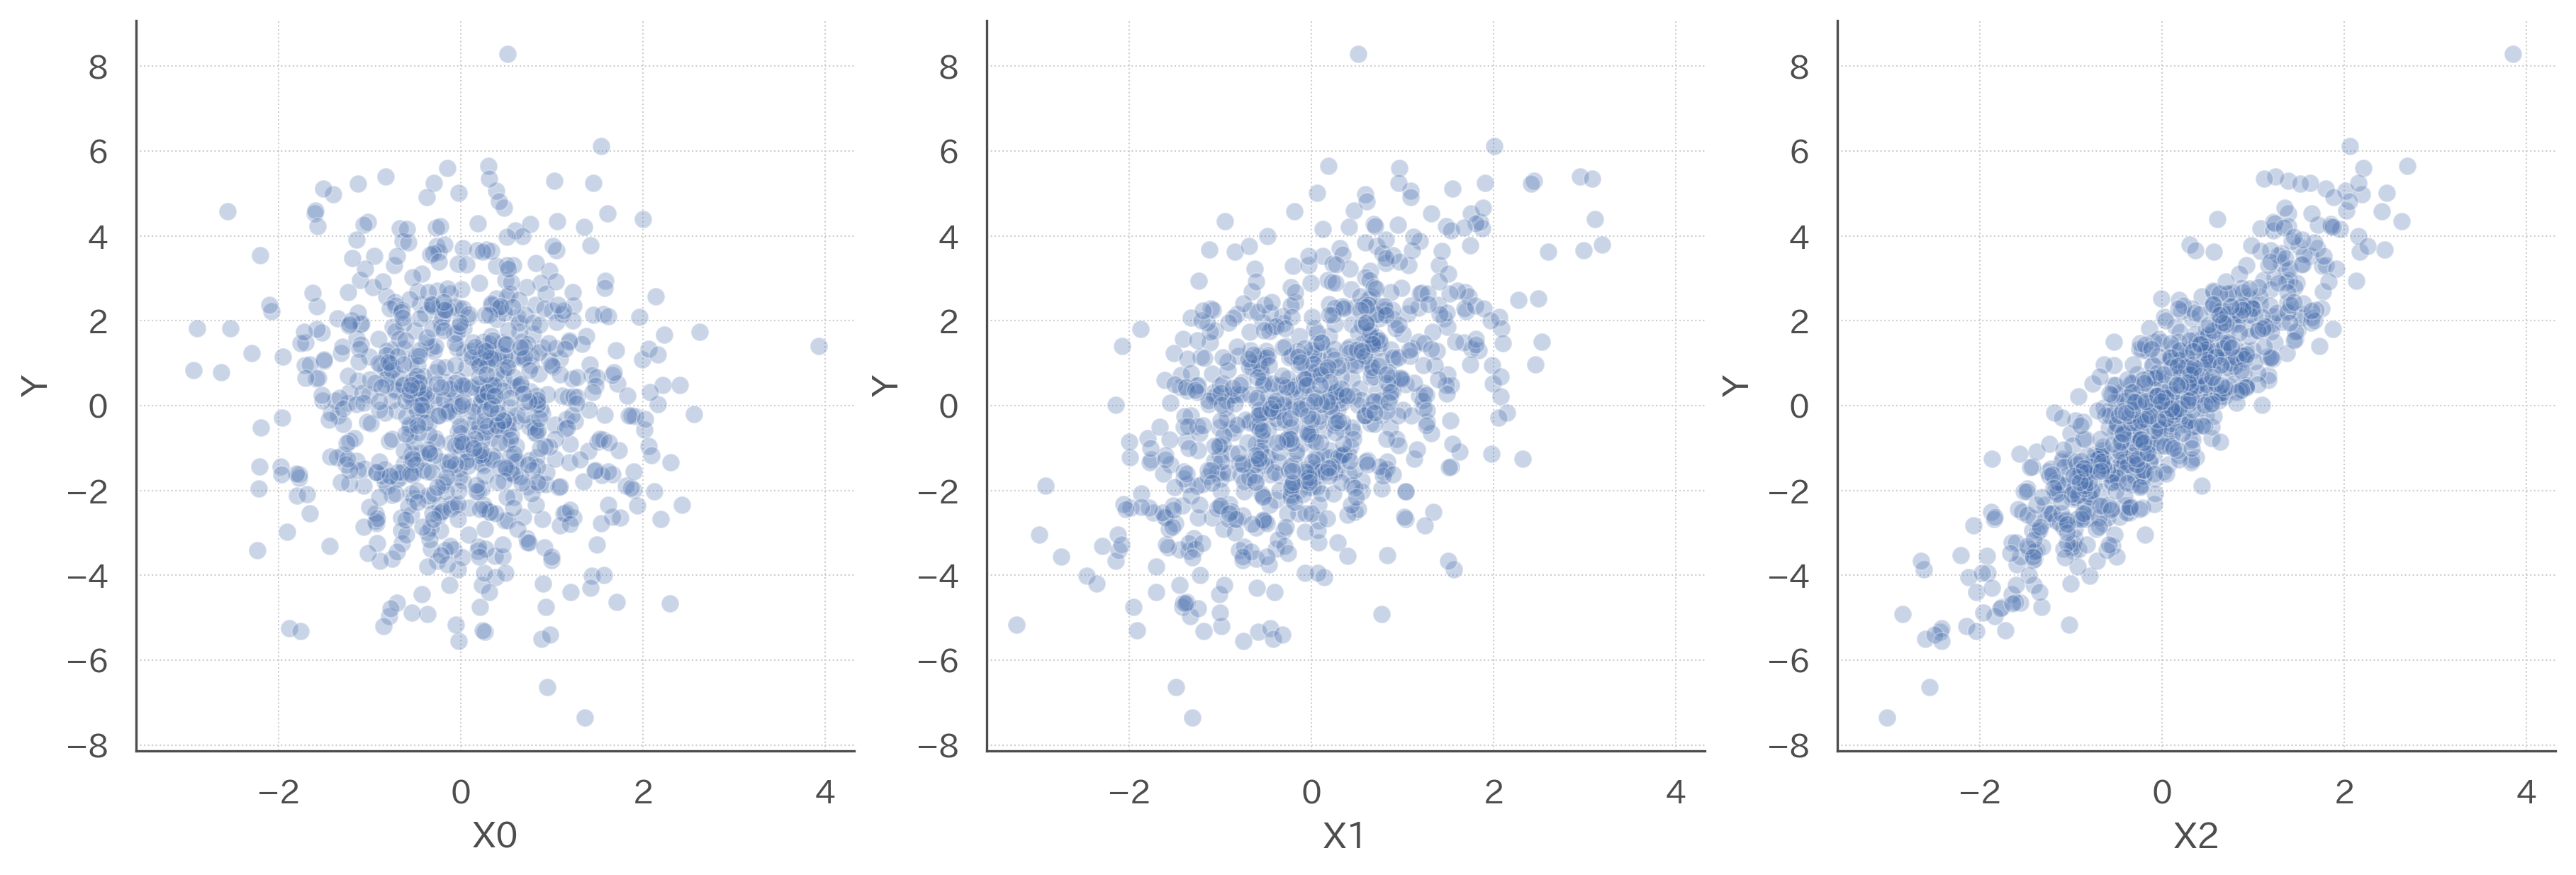

In [34]:
plot_scatter(X_train, y_train, var_names)

In [35]:
#### 3.2.3 線形回帰モデルの特徴量重要度

from sklearn.linear_model import LinearRegression

def plot_bar(variables, values, title = None, xlabel = None, ylabel = None):
    """回帰係数の大きさを確認する棒グラフを作成"""

    fig, ax = plt.subplots()
    ax.barh(variables, values)
    ax.set(xlabel = xlabel, ylabel = ylabel, xlim = (0, None))
    fig.suptitle(title)

    fig.show()



In [36]:
lm = LinearRegression().fit(X_train, y_train)

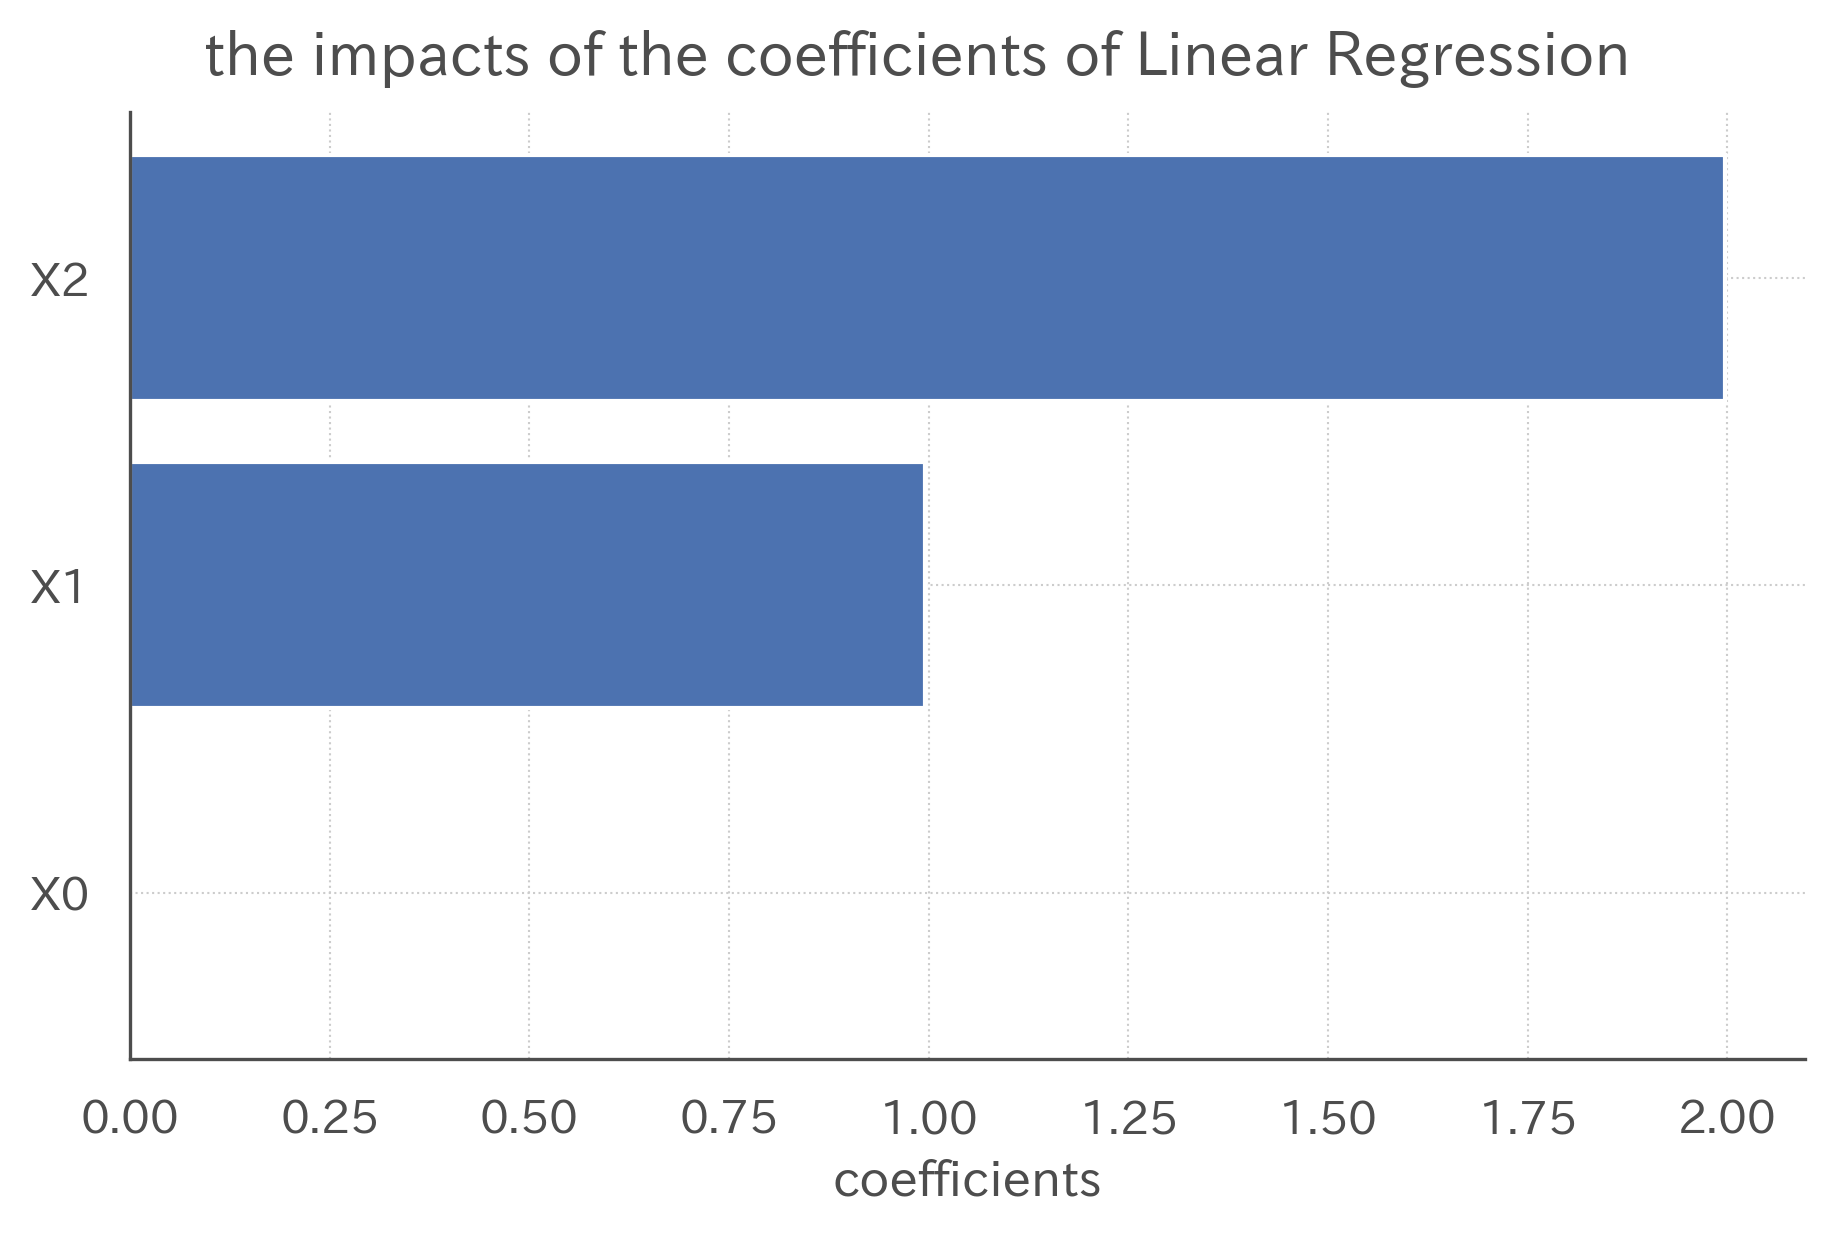

In [37]:
plot_bar(var_names, lm.coef_, "the impacts of the coefficients of Linear Regression", "coefficients")

#### 3.3 Permutation Feature Importance

- ブラックボックスモデルでは、線形回帰のように係数を解釈することが難しい
- 予測誤差を用いたアプローチを使って特徴量の重要性を評価する
  - それぞれの特徴量について、それが使えない時の誤差と、使える時の誤差を計算して、もし予測誤差が大きく増加するなら、その特徴量の情報が使えるかどうかが重要であり、ゆえにそのモデルではその特徴量が重視されていると考えることができる。


##### 3.3.1 PFIのアルゴリズム

- それぞれの特徴量について、ランダムに値をシャッフルすることで、実質的にその特徴量の情報が意味をなさない状況を作り出し、その状態での予測誤差を、その特徴量が使える時のベースラインのモデルの予測誤差と比較して重要度を割り出す。
- これを全ての特徴量について繰り返す。



In [53]:
from sklearn.metrics import mean_squared_error

@dataclass
class PermutationFeatureImportance:
    """Permuation Feature Importance

    Args:
        estimator:学習済みのモデル
        X:
        y:
        var_names:
    """
    estimator: Any
    X: np.ndarray
    y: np.ndarray
    var_names: list[str]

    def __post_init__(self) -> None:
        # シャッフルなしの場合の予測精度
        # squared = TrueならMSE
        # squared = FalseならRMSE
        self.baseline = mean_squared_error(
            self.y, self.estimator.predict(self.X), squared = False
        )

    def _permutation_metrics(self, idx_to_permute: int) -> float:
        """
        ある特徴量の値をシャッフルした時の予測精度
        Args:
            idx_to_permutate:シャッフルする特徴量のインデックス
        """

        X_permuted = self.X.copy()#シャッフルされないように新たにコピーして定義
        X_permuted[:, idx_to_permute] = np.random.permutation(X_permuted[:, idx_to_permute])
        y_pred = self.estimator.predict(X_permuted)

        return mean_squared_error(self.y, y_pred, squared = False)

    def permutation_feature_importance(self, n_shuffle: int = 10) -> None:
        """PFIを求める
        Args:
            n_shuffle: シャッフルの回数、多いほど安定する、デフォルトは10とする
        """

        J = self.X.shape[1]
        metrics_permuted = [
            np.mean(
                [self._permutation_metrics(j) for r in range(n_shuffle)]
            )
            for j in range(J)
        ]#permuted_metricsをr回計算して、その平均を採用することで値を安定させている


        df_feature_importance = pd.DataFrame(
            data = {
                "var_name": self.var_names,
                "baseline": self.baseline,
                "permutation": metrics_permuted,
                "difference": metrics_permuted - self.baseline,
                "ratio": metrics_permuted/self.baseline
            }
        )

        self.feature_importance = df_feature_importance.sort_values(
            "permutation", ascending=False
        )

    def plot(self, importance_type: str = "difference") -> None:
        """ Args:
            importance_type: PFIを差と比率のどちらで計算するか,defaultはdiff
        """
        fig, ax = plt.subplots()
        ax.barh(
            self.feature_importance["var_name"],
            self.feature_importance[importance_type],
            label = f"baseline: {self.baseline:.2f}"
        )
        ax.set(xlabel = importance_type, ylabel = None)
        ax.invert_yaxis()#重要度の大きさ順で
        ax.legend(loc = "lower right")
        fig.suptitle(f"Permutationによる特徴量の重要度({importance_type})")

        fig.show()









In [45]:
## PFIのシミュレーションデータへの適用

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs = -1, random_state = 42).fit(X_train, y_train)


In [46]:
from sklearn.metrics import r2_score

print(f"R2:{r2_score(y_test, rf.predict(X_test)):.2f}")

R2:0.99


In [54]:
# PFIのインスタンスの作成
pfi = PermutationFeatureImportance(estimator=rf, X = X_test, y = y_test, var_names = var_names)

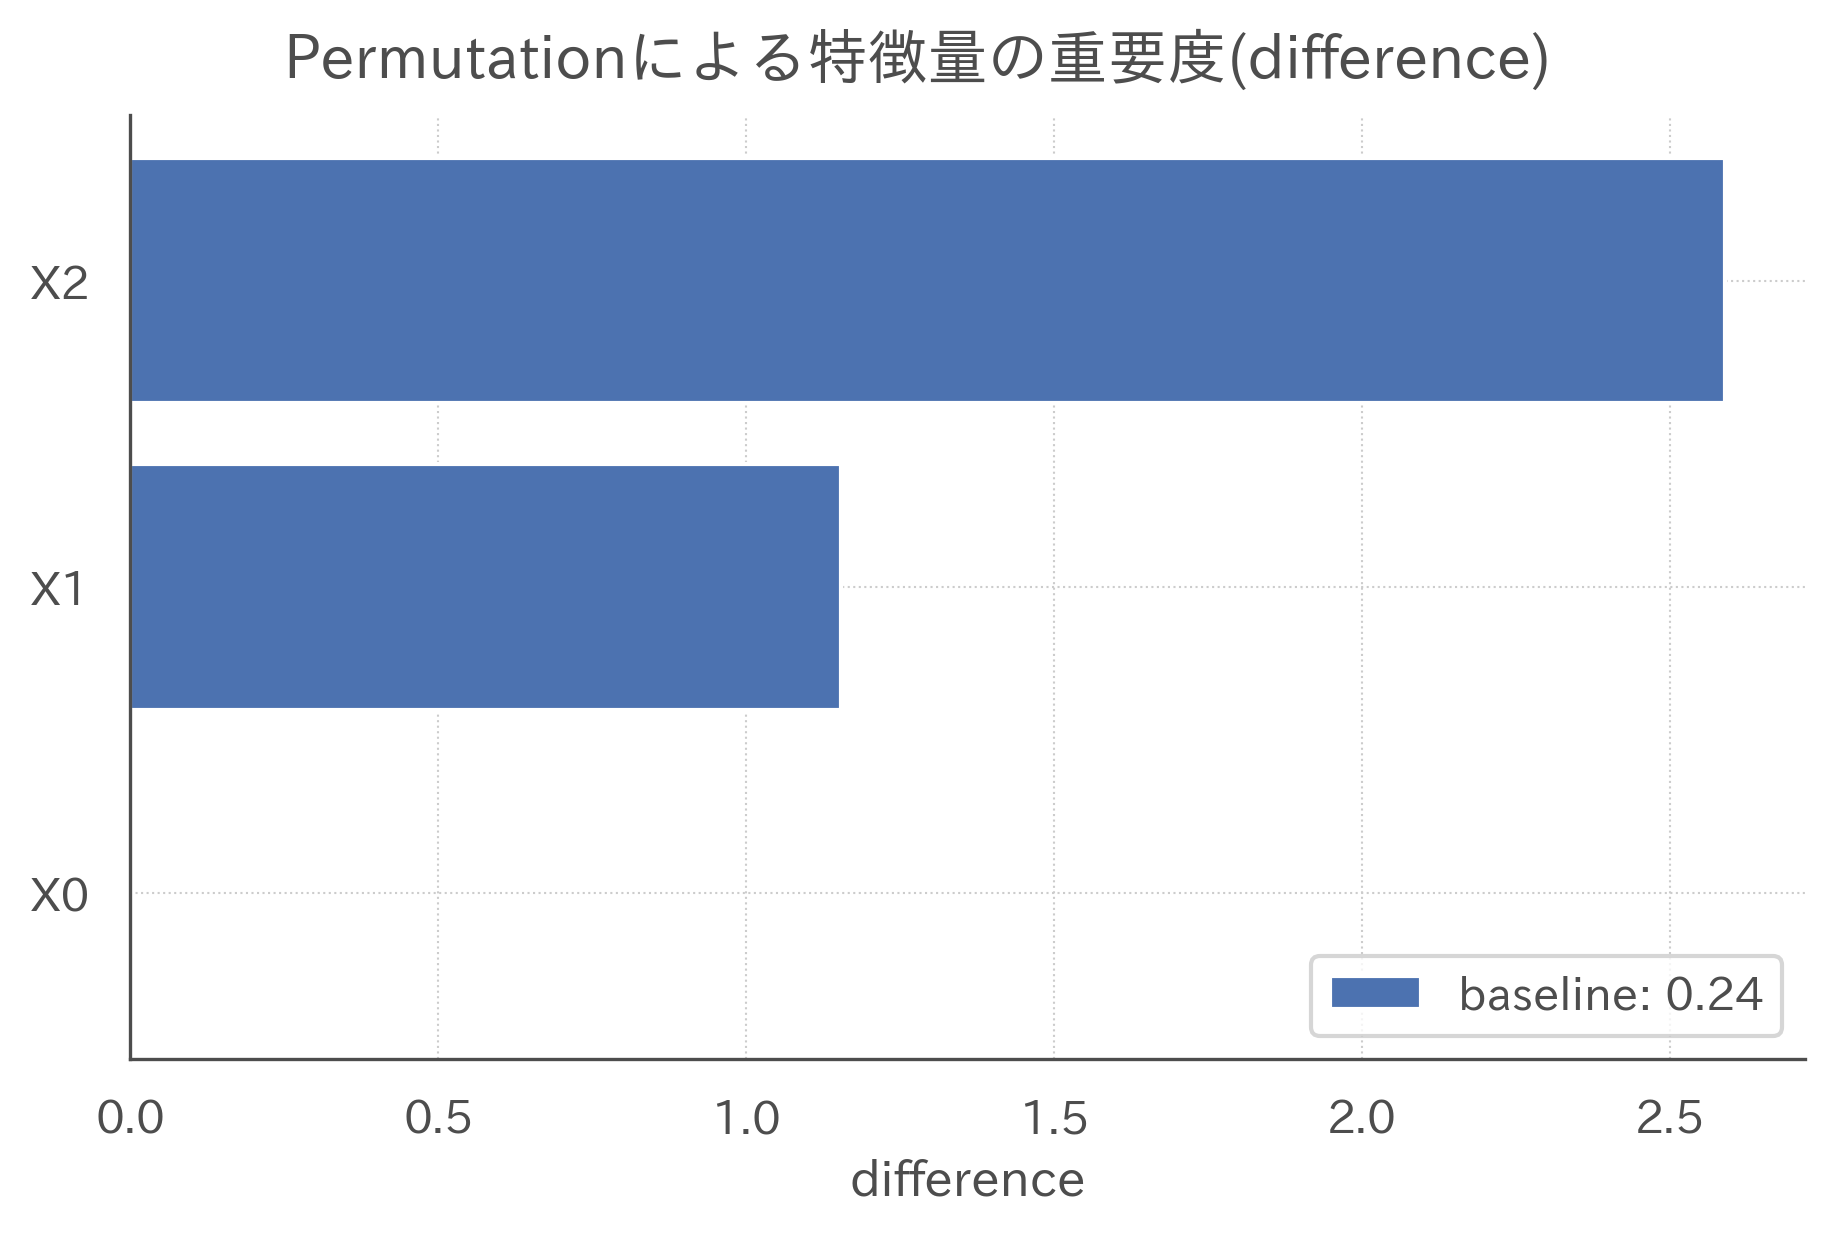

In [55]:
# PFIの計算 
pfi.permutation_feature_importance()

pfi.plot(importance_type = "difference")

#### 3.5 Grouped Permutation Feature Importance
##### 3.5.1 特徴量が相関するケース

特徴量同士が相関するケースおよび特徴量が複数集められて初めてグループとして解釈が成り立つような場合は、それらのグループごとにシャッフルするGPFIが重要度の計算に効果的


In [56]:
#### 3.5.2 GPFIの実装

class GroupedPermutationFeatureImportance(PermutationFeatureImportance):
    """Grouped Permutation Feature Importance
    PFIクラスを継承してるっぽい
    """
    def _permutation_metrics(
        self,
        var_names_to_permute: list[str]
    ) -> None:
        """"
        ある特徴量群の値をシャッフルした時の予測精度を求める
        Args:
            var_names_to_permute: シャッフルする特徴量グループの名前
        """
        X_permuted = self.X.copy()

        idx_to_permute = [
            self.var_names.index(v) for v in var_names_to_permute
        ]

        X_permuted[:, idx_to_permute] = np.random.permutation(
            X_permuted[:, idx_to_permute]
        )
        y_pred = self.estimator.predict(X_permuted)

        return mean_squared_error(self.y, y_pred, squared = False)

    def permutation_feature_importance(
        self, 
        var_groups: list[list[str]] | None,
        n_shuffle: int = 10
    ) -> None:
        """GPFIの計算

        Args:
            var_groups:
                グループ化された特徴量の名前のリスト、Noneなら通常のPFIが計算される
            n_shuffle:
                シャッフルする回数,default = 10

        """

        if var_groups is None:
            var_groups = [[j] for j in self.var_names]

        # グループごとに重要度を計算
        metrics_permuted = [
            np.mean([self._permutation_metrics(j) for r in range(n_shuffle)])
            for j in var_groups
        ]

        # データフレームにしてまとめる

        df_feature_importance = pd.DataFrame(
            data = {
                "var_name": ["+".join(j) for j in var_groups],
                "baseline": self.baseline,
                "permutation": metrics_permuted,
                "difference": metrics_permuted - self.baseline,
                "ratio": metrics_permuted/self.baseline
            }
        )
        
        self.feature_importance = df_feature_importance.sort_values(
            "permutation", ascending=False
            )


In [57]:
X_train2 = np.concatenate([X_train, X_train[:, [2]]], axis = 1)

In [58]:
rf = RandomForestRegressor(n_jobs = -1, random_state = 42).fit(X_train2, y_train)

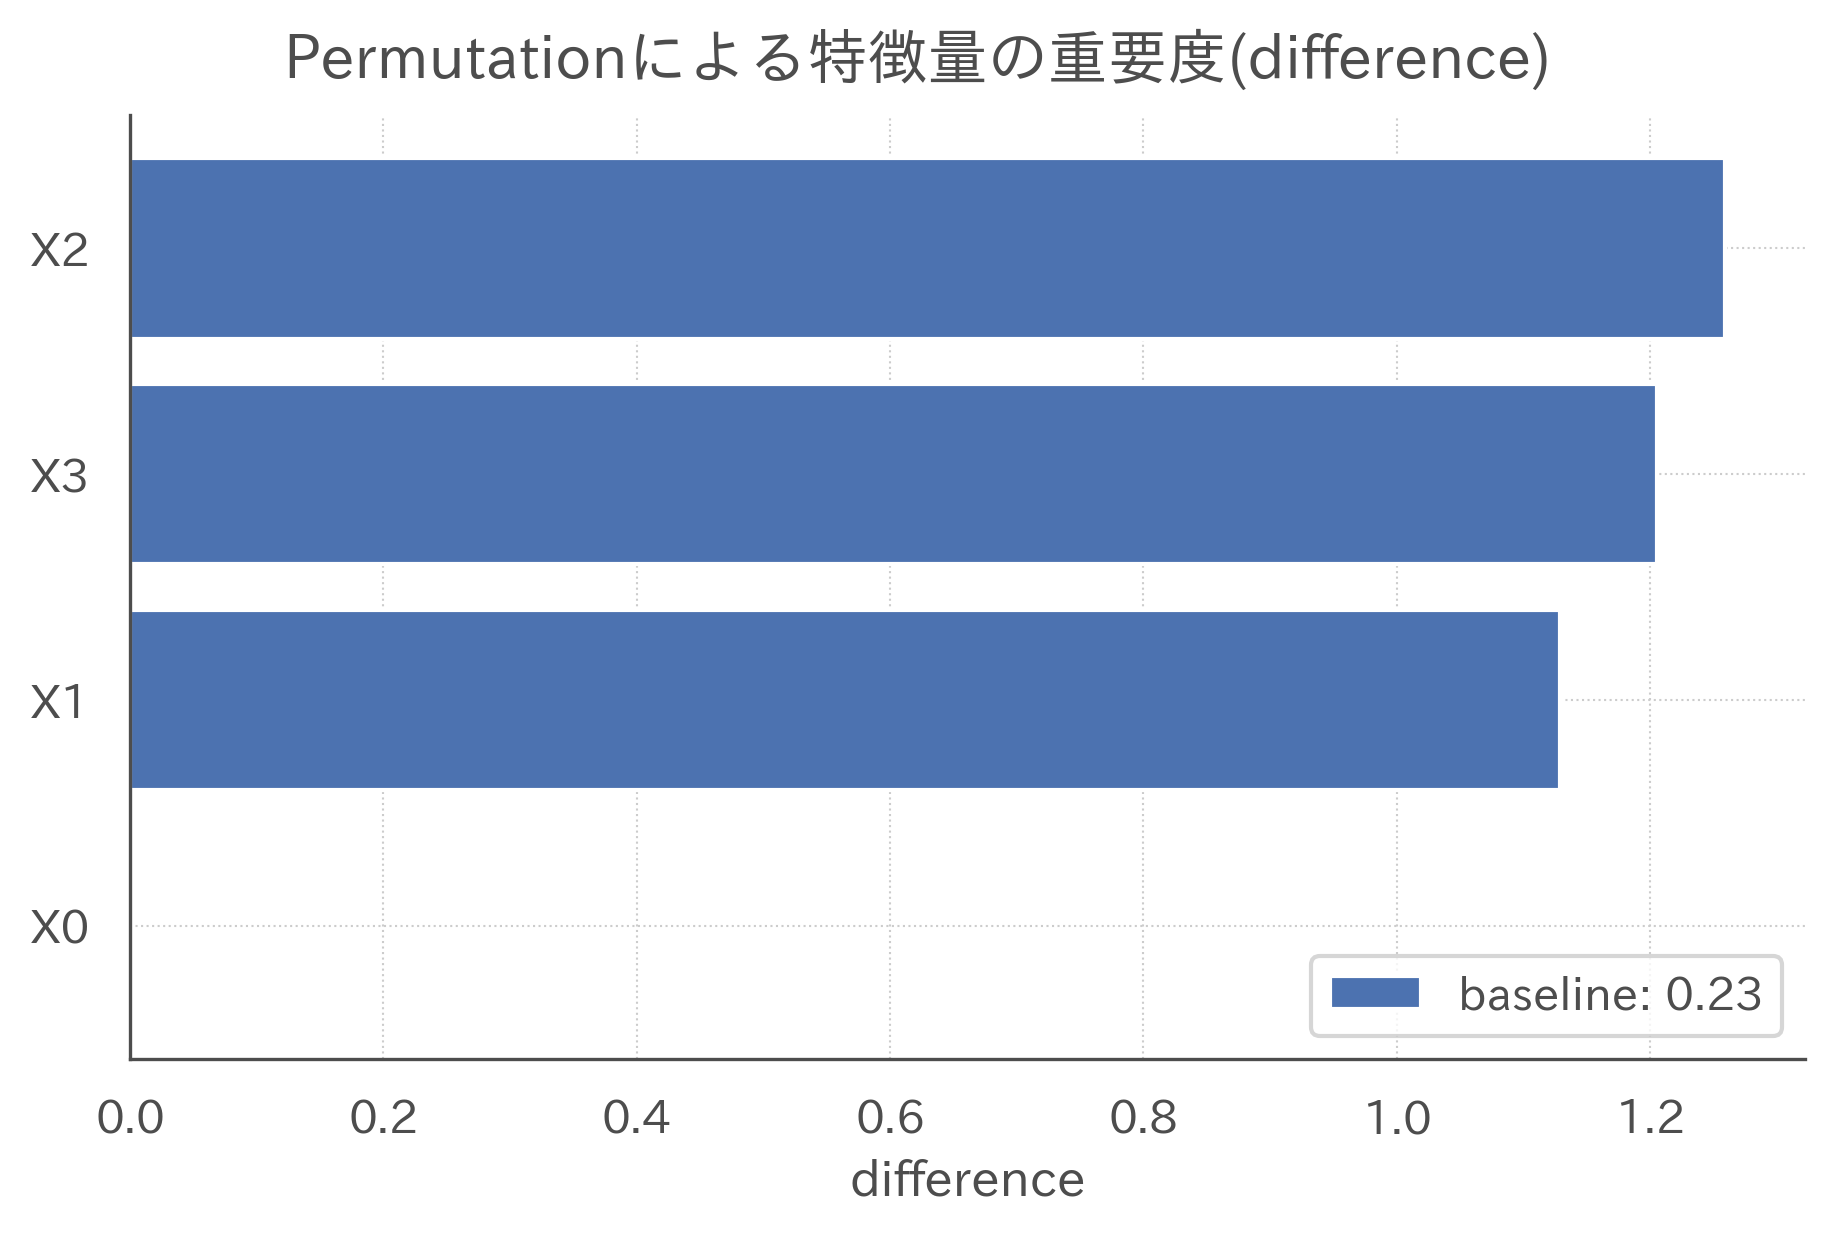

In [61]:
X_test2 = np.concatenate([X_test, X_test[:, [2]]], axis = 1)

gpfi = GroupedPermutationFeatureImportance(
    estimator=rf, X = X_test2, y = y_test, var_names = ["X0", "X1", "X2", "X3"]
)

# var_groupsを指定しないで計算すると、そのままのPFIが出力される
gpfi.permutation_feature_importance(var_groups=None)#PFI

gpfi.plot()



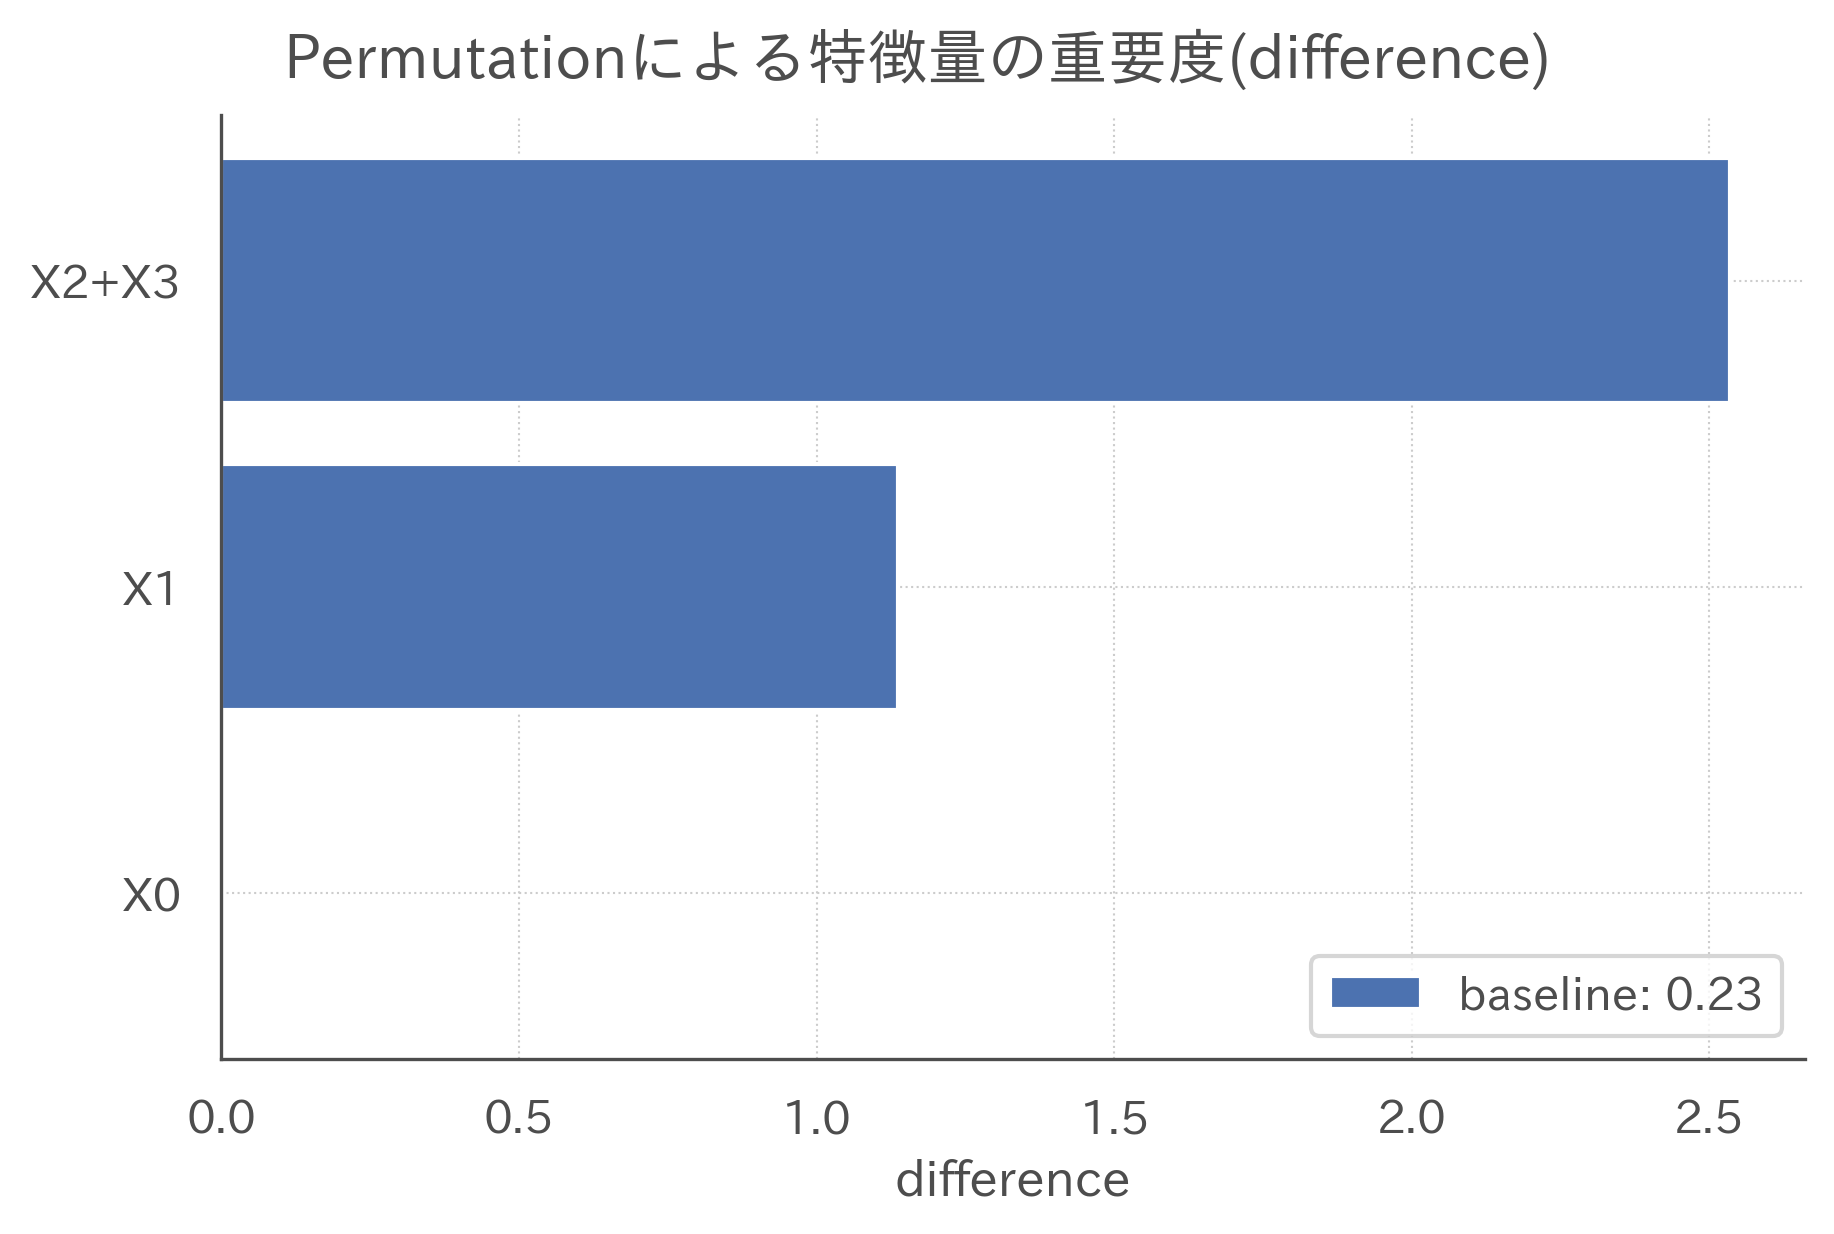

In [62]:
# X2とX3は強く相関するのでまとめてシャッフル、X0とX1は個別にシャッフル

gpfi.permutation_feature_importance(var_groups = [["X0"], ["X1"], ["X2", "X3"]])#GPFI

gpfi.plot()


#### 3.8 実データでの分析

In [65]:
import joblib

X_train, X_test, y_train, y_test = joblib.load("/Users/tidyjin/scripts/ml_topics/ex_ml/ml_inter/data/boston_housing.pkl")
rf = joblib.load("/Users/tidyjin/scripts/ml_topics/ex_ml/ml_inter/model/boston_housing_rf.pkl")

In [66]:
from sklearn.inspection import permutation_importance

pfi = permutation_importance(
    estimator = rf, 
    X = X_test,
    y = y_test,
    scoring = "neg_root_mean_squared_error", 
    n_repeats = 5,
    n_jobs = -1,
    random_state = 42
)

pfi

/Users/tidyjin/scripts/ml_topics/ex_ml/ml_inter/.venv/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/tidyjin/scripts/ml_topics/ex_ml/ml_inter/.venv/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/tidyjin/scripts/ml_topics/ex_ml/ml_inter/.venv/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/tidyjin/scripts/ml_topics/ex_ml/ml_inter/.venv/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Users/tidyjin/scripts/ml_topics/ex_ml/ml_inter/.venv/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but Ra

{'importances_mean': array([0.47335366, 0.00767681, 0.0488425 , 0.00577725, 0.39998356,
        3.71527662, 0.17887136, 0.94838591, 0.0314633 , 0.11882726,
        0.2915789 , 0.02083006, 3.54059205]),
 'importances_std': array([0.0364208 , 0.00788286, 0.01233191, 0.00195267, 0.04552138,
        0.10845402, 0.03142234, 0.51582081, 0.00712065, 0.03561518,
        0.05189719, 0.03750401, 0.55511839]),
 'importances': array([[ 4.21780470e-01,  4.47578199e-01,  5.24408599e-01,
          4.73160410e-01,  4.99840633e-01],
        [ 3.82160776e-03,  1.44580414e-02,  1.84218654e-02,
          5.36588658e-03, -3.68333178e-03],
        [ 4.75590731e-02,  5.98691482e-02,  6.53492096e-02,
          3.25437839e-02,  3.88913056e-02],
        [ 8.44613611e-03,  3.60372142e-03,  7.20979226e-03,
          3.52744355e-03,  6.09918045e-03],
        [ 3.70942819e-01,  3.32201627e-01,  4.57748542e-01,
          4.39806226e-01,  3.99218573e-01],
        [ 3.71381796e+00,  3.83244494e+00,  3.53957912e+00,
  

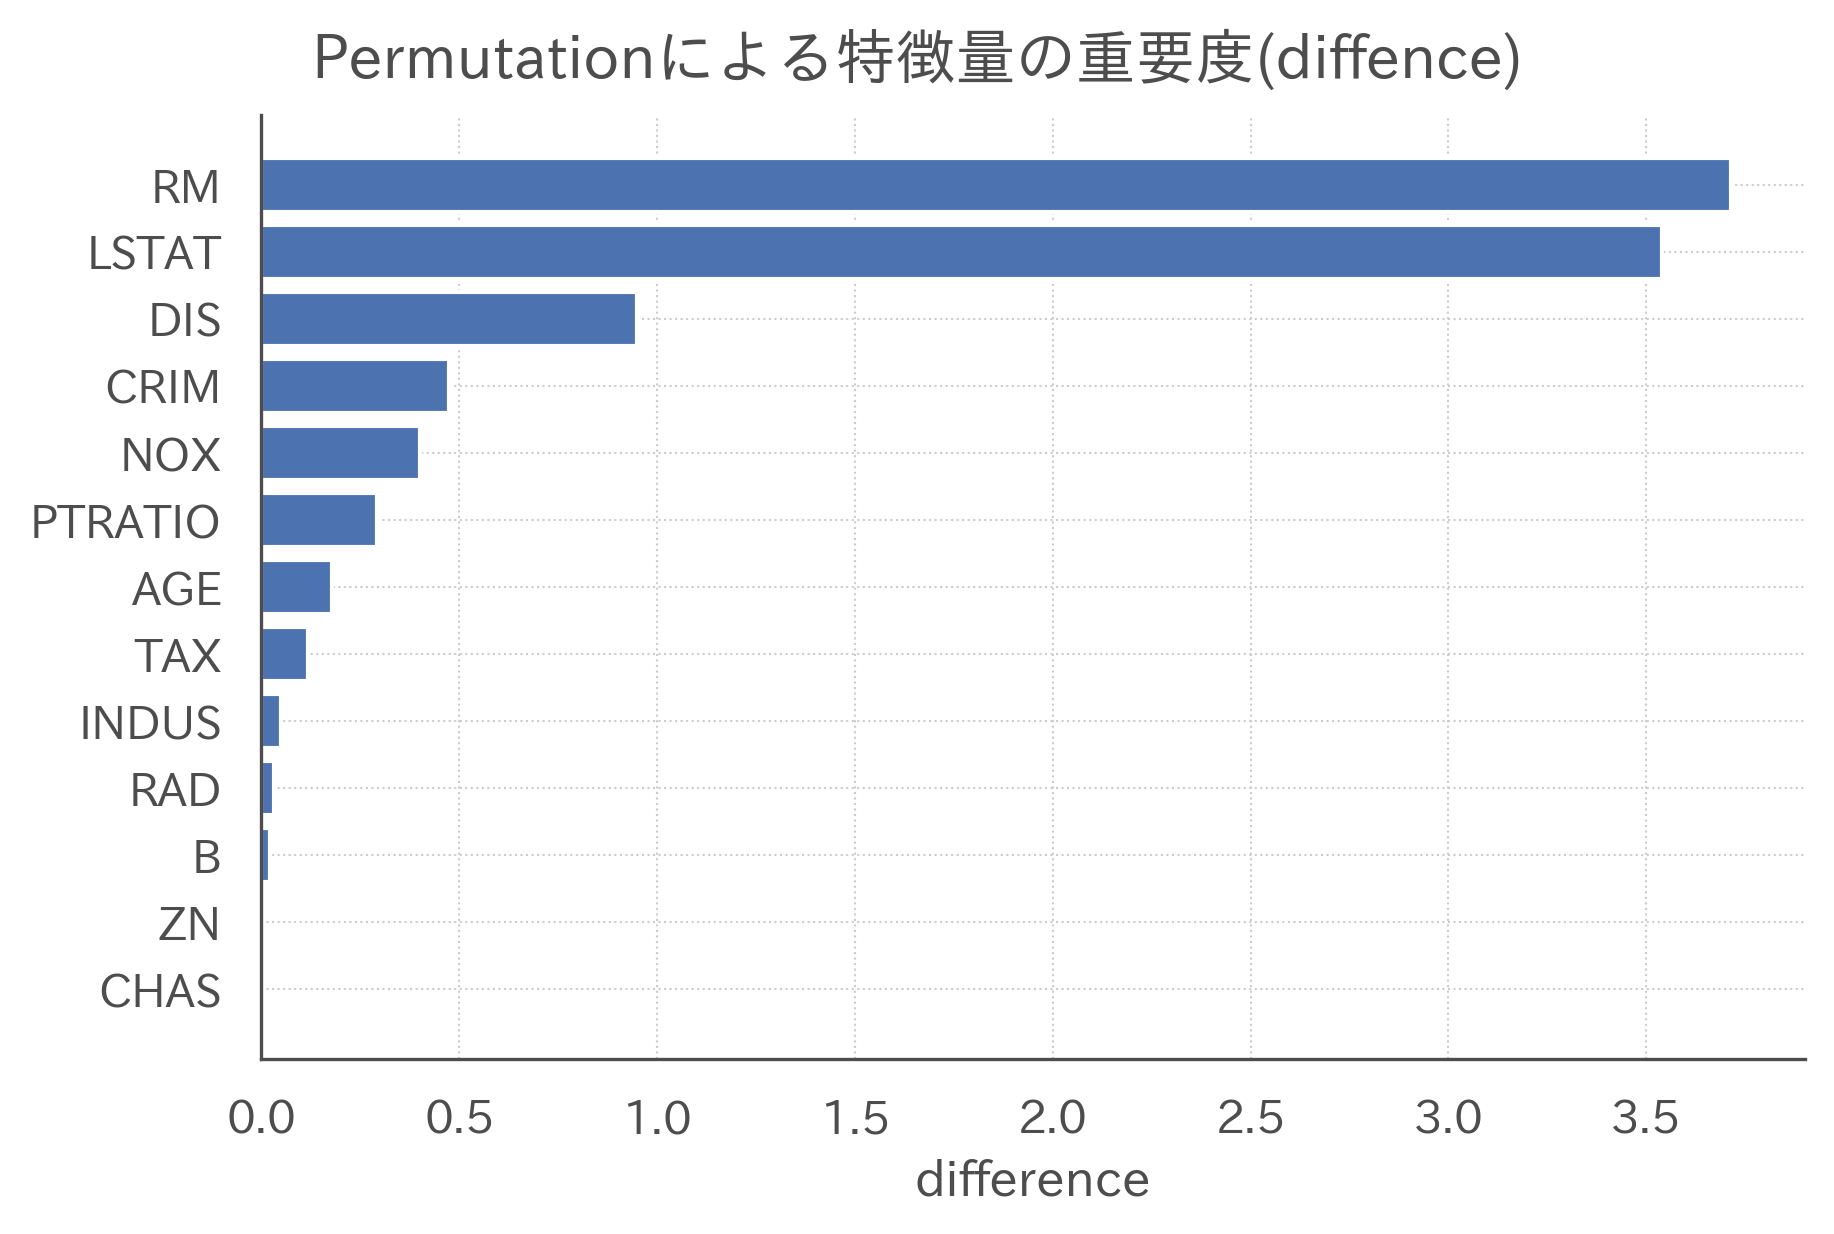

In [68]:
df_pfi = pd.DataFrame(
    data = {"var_name":X_test.columns, "importance":pfi["importances_mean"]}
).sort_values("importance")

## PFIを可視化

plot_bar(df_pfi["var_name"],
df_pfi["importance"],
xlabel = "difference",
title = "Permutationによる特徴量の重要度(diffence)")
